# Channel Head Coupling Analysis

This notebook analyzes the coupling between channel heads in a drainage network derived from a DEM using **TopoToolbox (Python)**.  
We:
- Load the DEM and derive flow and stream networks.
- Identify outlets, confluences, and channel heads.
- Compute *first-meet pairs* of channel heads per confluence.
- Evaluate which pairs are *coupled* (touching).
- Visualize coupled pairs and outlet subgraphs.

---

In [2]:
# === Setup ===
import sys, pathlib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import topotoolbox as tt3
import topotoolbox._stream as _stream

# Add project root so "channel_heads" package is visible
project_root = pathlib.Path("/Users/guypi/Projects/channel-heads")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Imports from your channel_heads package
from channel_heads.first_meet_pairs_for_outlet import first_meet_pairs_for_outlet
from channel_heads.coupling_analysis import CouplingAnalyzer
from channel_heads.stream_utils import outlet_node_ids_from_streampoi
from channel_heads.plotting_utils import (
    plot_coupled_pair,
    plot_outlet_view,
    plot_all_coupled_pairs_for_outlet,
    plot_all_coupled_pairs_for_outlet_3d
)

## 1. Load and Preprocess DEM

We load the SRTM DEM from disk and mask out low elevation values (<1200 m).  
A basic visualization helps confirm the data integrity.

In [ ]:
dem = tt3.read_tif("/Users/guypi/Projects/channel-heads/data/cropped_DEMs/Inyo_strm_crop.tif")
dem.info()

# Mask out low elevations
dem.z[dem.z < 1200] = np.nan

fig, ax = plt.subplots(figsize=(8,6))
im = dem.plot(ax=ax, cmap='terrain')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
plt.colorbar(im, ax=ax, label="Elevation (m)")

## 2. Flow and Stream Network

We derive a `FlowObject` from the DEM and create a `StreamObject` using a threshold area.

In [ ]:
fd = tt3.FlowObject(dem)
s = tt3.StreamObject(fd, threshold=300)

fig, ax = plt.subplots(figsize=(8,6))
dem.plot(ax=ax, cmap='terrain')
s.plot(ax=ax, color='blue', linewidth=1)
ax.set_title("Stream Network over DEM")
plt.show()

In [ ]:
outlet_mask = s.streampoi('outlets')
conf_mask   = s.streampoi('confluences')
heads_mask  = s.streampoi('channelheads')

outlet_ids = np.flatnonzero(outlet_mask)

print("POIs:")
print("  outlets:", int(outlet_mask.sum()))
print("  confluences:", int(conf_mask.sum()))
print("  channel heads:", int(heads_mask.sum()))
print("First 10 outlet node-ids:", outlet_ids[:10])

In [ ]:
by_outlet = {}

for o in outlet_ids:
    single_outlet_mask = np.zeros_like(outlet_mask, dtype=bool)
    single_outlet_mask[o] = True

    s_up_o = s.upstreamto(single_outlet_mask)
    conf_o = s_up_o.streampoi('confluences')
    conf_ids_o = np.flatnonzero(conf_o)

    heads_by_conf = {}
    for c_local in conf_ids_o:
        c_mask_local = np.zeros_like(conf_o, dtype=bool)
        c_mask_local[c_local] = True
        s_up_c = s_up_o.upstreamto(c_mask_local)
        head_ids_c = np.flatnonzero(s_up_c.streampoi('channelheads'))
        heads_by_conf[c_local] = head_ids_c

    by_outlet[o] = {
        "s_up": s_up_o,
        "confluences_local": conf_ids_o,
        "heads_by_confluence_local": heads_by_conf,
    }

# Compact print (optional)
for o, data in list(by_outlet.items())[:-1]:
    print(f"\nOutlet {o}:")
    print(f"  - Number of confluences: {len(data['confluences_local'])}")
    for c_local in data["confluences_local"]:
        heads_local = data["heads_by_confluence_local"].get(c_local, [])
        print(f"    Confluence {c_local}: {len(heads_local)} heads -> {heads_local}")

### channel-head coupeling

In [ ]:
from channel_heads.coupling_analysis import CouplingAnalyzer
an = CouplingAnalyzer(fd, s, dem, connectivity=8)

In [ ]:
outs = outlet_node_ids_from_streampoi(s)
print("Found", len(outs), "outlets.")
print("Outlet node IDs:", outs[:-1])

In [ ]:
# === choose outlet ===
o = outs[4]
print("Selected outlet node id:", o)

# === run the same downstream logic ===
pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, o)
an = CouplingAnalyzer(fd, s, dem)
df = an.evaluate_pairs_for_outlet(o, pairs_at_confluence)
df.head()

In [ ]:
def compute_coupling_all_outlets(s, fd, dem, outlets=None, warmup=True, connectivity=8):
    """
    Build a single DataFrame of coupling results for all (or selected) outlets.

    Columns:
      outlet, confluence, head_1, head_2, touching, overlap_px, contact_px, size1_px, size2_px
    """
    # 0) pick outlets
    if outlets is None:
        outlets = outlet_node_ids_from_streampoi(s)
    outlets = [int(o) for o in outlets]

    # 1) analyzer (we’ll reuse it; clear its cache per outlet to bound memory)
    an = CouplingAnalyzer(fd, s, dem, connectivity=connectivity)

    dfs = []
    for idx, o in enumerate(outlets, 1):
        # print small progress breadcrumb
        print(f"[{idx}/{len(outlets)}] outlet={o}", flush=True)

        # 2) first-meet pairs for this outlet
        pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, o)

        # 3) optional warm-up: precompute masks for heads in this basin
        if warmup and basin_heads:
            an._mask_cache.clear()          # keep cache limited per outlet
            # touch each head once to populate cache
            for h in basin_heads:
                _ = an.influence_mask(int(h))

        # 4) evaluate pairs → per-outlet DataFrame
        df_o = an.evaluate_pairs_for_outlet(o, pairs_at_confluence)
        if not df_o.empty:
            dfs.append(df_o)

    # 5) concat
    if not dfs:
        cols = ["outlet","confluence","head_1","head_2","touching","overlap_px","contact_px","size1_px","size2_px"]
        return pd.DataFrame(columns=cols)

    df_all = pd.concat(dfs, ignore_index=True)
    # nice ordering
    df_all.sort_values(["outlet","confluence","head_1","head_2"], inplace=True, ignore_index=True)
    return df_all

In [ ]:
# All outlets
outs = outlet_node_ids_from_streampoi(s)
print("Found", len(outs), "outlets.")

df_all = compute_coupling_all_outlets(s, fd, dem, outlets=outs, warmup=True, connectivity=8)

print("Total pairs evaluated:", len(df_all))
print("Overall touching rate:", df_all["touching"].mean() if not df_all.empty else 0.0)
df_all.head()

In [ ]:
df_touching = df_all[df_all["touching"] == True].copy()
print("Touching pairs:", len(df_touching))

In [ ]:
df_touching.sort_values(
    ["outlet", "confluence", "head_1", "head_2"],
    inplace=True,
    ignore_index=True
)
df_touching.head(20)

In [ ]:
summary_touch = (
    df_touching.groupby("outlet")
               .size()
               .reset_index(name="n_touching_pairs")
               .sort_values("n_touching_pairs", ascending=False)
)
summary_touch.head(10)

In [ ]:
plot_outlet_view(s, 1097, dem, view_mode="overview")



# overview of all pairs still needs 'an'
plot_all_coupled_pairs_for_outlet(fd, s, dem, an, df_touching, 1097, view_mode="crop")

In [ ]:
# === Taiwan DEM Analysis ===
# Load Taiwan DEM and plot outlet 8103

from channel_heads import get_z_th

dem_taiwan = tt3.read_tif("/Users/guypi/Projects/channel-heads/data/cropped_DEMs/Taiwan_strm_crop.tif")
dem_taiwan.info()

# Mask out low elevations using basin config
z_th_taiwan = get_z_th("taiwan")  # 80m
print(f"Elevation threshold: {z_th_taiwan} m")
dem_taiwan.z[dem_taiwan.z < z_th_taiwan] = np.nan

# Derive flow and stream networks
fd_taiwan = tt3.FlowObject(dem_taiwan)
s_taiwan = tt3.StreamObject(fd_taiwan, threshold=145)

# Check outlets
outs_taiwan = outlet_node_ids_from_streampoi(s_taiwan)
print(f"Found {len(outs_taiwan)} outlets")
print(f"Outlet 8109 present: {8109 in outs_taiwan}")

name: Taiwan_strm_crop
path: /Users/guypi/Projects/channel-heads/data/cropped_DEMs/Taiwan_strm_crop.tif
rows: 2118
cols: 1957
cellsize: 0.000833333333333144
bounds: BoundingBox(left=120.32291666659843, bottom=22.921250000008428, right=121.95374999993139, top=24.686250000008027)
transform: | 0.00, 0.00, 120.32|
| 0.00,-0.00, 24.69|
| 0.00, 0.00, 1.00|
coordinate system (Geographic): EPSG:4326
maximum z-value: 3917.0
minimum z-value: -28.0
Elevation threshold: 80 m
Found 426 outlets
Outlet 8103 present: True


(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Outlet 8109 (overview)'}>)

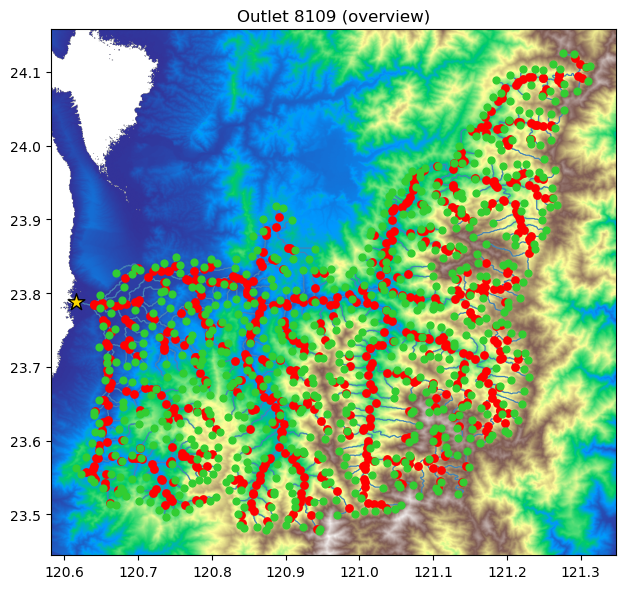

In [6]:
# Plot outlet 8109 in Taiwan DEM
plot_outlet_view(s_taiwan, 8109, dem_taiwan, view_mode="overview")